In [1]:
from pathlib import Path
from pyvis.network import Network
import re

# Sanitize code

In [2]:
def remove_block_comment(code: str) -> str:
    regex = r"/\*[\s\S]*?\*/"
    return re.sub(regex, '', code, flags=re.MULTILINE)

def remove_single_line_comment(code: str) -> str:
    # regex = r"^.*(--.*)$"
    regex = r"(.*?)(--.*$)"
    # return re.sub(regex, '', code, flags=re.MULTILINE)
    return re.sub(regex, r'\1', code, flags=re.MULTILINE)

In [3]:
# s = """
# test
# /* this
# is the 
# /* beginning 
# of 
# /* a comment */
# foo
# """

# print(remove_block_comment(s))


# s = """
# test
# -- This is wrong
# line of code -- foo

# OK
# """

# print(remove_single_line_comment(s))

In [4]:
for file in Path("../codebase").glob("*.pkb"):
    code = file.read_text().lower()
    package_name = file.stem
    break

In [5]:
code = remove_block_comment(code)
code = remove_single_line_comment(code)

In [6]:
with open("test.pks", "w") as f:
    f.write(code)

# Parse

In [7]:
def extract_function(pl_sql_code: str, package_name: str) -> list:

    # Updated regular expressions for matching functions and procedures
    function_pattern = re.compile(r'(?i)(?:CREATE\s+(?:OR\s+REPLACE\s+)?)?FUNCTION\s+(\w+)', re.MULTILINE)
    procedure_pattern = re.compile(r'(?i)(?:CREATE\s+(?:OR\s+REPLACE\s+)?)?PROCEDURE\s+(\w+)', re.MULTILINE)
    
    # Find all functions and procedures
    functions = function_pattern.finditer(pl_sql_code)
    procedures = procedure_pattern.finditer(pl_sql_code)
    
    results = []

    for match in list(functions) + list(procedures):
        name = match.group(1)
        start = match.start()
        
        # Find the corresponding END
        end_match = re.search(r'(?i)\bEND\s+' + re.escape(name) + r'\s*;', pl_sql_code[start:])
        if end_match:
            end = start + end_match.end()
            body = pl_sql_code[start:end]
            
            # Check if it has BEGIN/END
            has_begin_end = 'BEGIN' in body.upper() and 'END' in body.upper()
            
            # Determine if it's a function or procedure
            type_ = 'FUNCTION' if 'FUNCTION' in body.upper() else 'PROCEDURE'
            
            results.append({
                'name': f"{package_name}.{name}",
                'type': type_,
                'has_begin_end': has_begin_end,
                'body': body.strip()
            })
    return results

In [8]:
def extract_function_call(package_content: str, package_name: str):
    call_pattern = re.compile(r'(\w+\.)?(\w+)\s*\(', re.IGNORECASE)            
    calls = []
    for call_match in call_pattern.finditer(package_content):
        package_prefix = call_match.group(1)
        function_name = call_match.group(2)
        if package_prefix:
            calls.append(f"{package_prefix}{function_name}")
        else:
            calls.append(f"{package_name}.{function_name}")
    return list(set(calls))

In [9]:
def extract_tables(plsql_function: str) -> list[str]:
    # Convert to uppercase for case-insensitive matching
    plsql_function = plsql_function.upper()
    
    # Patterns to match table names in various SQL contexts
    patterns = [
        r'\bFROM\s+(\w+)',                  # SELECT ... FROM table
        r'\bJOIN\s+(\w+)',                  # JOIN table
        r'\bUPDATE\s+(\w+)',                # UPDATE table
        r'\bINTO\s+(\w+)',                  # INSERT INTO table
        r'\bDELETE\s+FROM\s+(\w+)',         # DELETE FROM table
        r'\bALTER\s+TABLE\s+(\w+)',         # ALTER TABLE table
        r'\bCREATE\s+TABLE\s+(\w+)',        # CREATE TABLE table
        r'\bDROP\s+TABLE\s+(\w+)',          # DROP TABLE table
        r'\bTRUNCATE\s+TABLE\s+(\w+)',      # TRUNCATE TABLE table
        r':(\w+)%ROWTYPE',                  # variable_name table%ROWTYPE
        r'\bTABLE\s*\(\s*(\w+)',            # TABLE(table_name) for collection expressions
    ]
    
    tables = set()
    
    for pattern in patterns:
        matches = re.findall(pattern, plsql_function)
        tables.update(matches)
    
    # Remove common SQL keywords that might be mistaken for table names
    keywords = {'SELECT', 'FROM', 'WHERE', 'AND', 'OR', 'UNION', 'MINUS', 'INTERSECT', 'ORDER', 'GROUP', 'HAVING', 'BY', 'ASC', 'DESC'}
    tables = tables - keywords
    
    return sorted(list(tables))

In [10]:
with open("test.pks", "r") as f:
    code = f.read()

In [11]:
analysis_results = extract_function(code, package_name)

for item in analysis_results:
    print(f"Name: {item['name']}")
    print(f"Type: {item['type']}")
    item["calls"] = extract_function_call(item['body'], package_name)
    item["tables"] = extract_tables(item['body'])
    # print(f"Has BEGIN/END: {item['has_begin_end']}")
    # print("Body:")
    # print(item['body'])
    # print("-" * 50)

print(analysis_results)

Name: amazon_aws_auth_pkg.get_auth_string
Type: FUNCTION
Name: amazon_aws_auth_pkg.get_signature
Type: FUNCTION
Name: amazon_aws_auth_pkg.get_aws_id
Type: FUNCTION
Name: amazon_aws_auth_pkg.get_date_string
Type: FUNCTION
Name: amazon_aws_auth_pkg.get_epoch
Type: FUNCTION
Name: amazon_aws_auth_pkg.set_aws_id
Type: PROCEDURE
Name: amazon_aws_auth_pkg.set_aws_key
Type: PROCEDURE
Name: amazon_aws_auth_pkg.set_gmt_offset
Type: PROCEDURE
Name: amazon_aws_auth_pkg.init
Type: PROCEDURE
[{'name': 'amazon_aws_auth_pkg.get_auth_string', 'type': 'FUNCTION', 'has_begin_end': True, 'body': "function get_auth_string (p_string in varchar2) return varchar2\nas\n l_returnvalue      varchar2(32000);\n l_encrypted_raw    raw (2000);             \n l_decrypted_raw    raw (2000);             \n l_key_bytes_raw    raw (64);               \nbegin\n\n  \n\n  l_key_bytes_raw := utl_i18n.string_to_raw (g_aws_key,  'al32utf8');\n  l_decrypted_raw := utl_i18n.string_to_raw (p_string, 'al32utf8');\n\n  l_encrypted_

In [12]:
for item in analysis_results:
    print(f"Name: {item['name']}")
    print(item['tables'])

Name: amazon_aws_auth_pkg.get_auth_string
[]
Name: amazon_aws_auth_pkg.get_signature
[]
Name: amazon_aws_auth_pkg.get_aws_id
[]
Name: amazon_aws_auth_pkg.get_date_string
[]
Name: amazon_aws_auth_pkg.get_epoch
[]
Name: amazon_aws_auth_pkg.set_aws_id
[]
Name: amazon_aws_auth_pkg.set_aws_key
[]
Name: amazon_aws_auth_pkg.set_gmt_offset
[]
Name: amazon_aws_auth_pkg.init
[]


# All in one

In [13]:
all_procedures = []
for file in Path("../codebase").glob("*.pkb"):
    package_name = file.stem
    try:
        code = file.read_text().lower()
        
        code = remove_block_comment(code)
        code = remove_single_line_comment(code)

        analysis_results = extract_function(code, package_name)

        for item in analysis_results:
            item["calls"] = extract_function_call(item['body'], package_name)
            item["tables"] = extract_tables(item['body'])

        all_procedures += analysis_results
        print(package_name, "OK")
    except Exception as e:
        print(package_name, f"FAIL: {e}")

amazon_aws_auth_pkg OK
amazon_aws_s3_pkg OK
apex_util_pkg OK
crypto_util_pkg OK
csv_util_pkg OK
datapump_util_pkg OK
date_util_pkg OK
debug_pkg OK
encode_util_pkg OK
file_util_pkg OK
flex_ws_api OK
ftp_util_pkg OK
gis_util_pkg OK
google_maps_js_pkg OK
google_maps_pkg OK
google_translate_pkg OK
html_util_pkg OK
http_util_pkg OK
icalendar_util_pkg OK
image_util_pkg OK
json_util_pkg OK
math_util_pkg OK
ms_ews_util_pkg OK
ntlm_http_pkg OK
ntlm_util_pkg OK
ooxml_util_pkg OK
owa_util_pkg OK
paypal_util_pkg OK
pdf_builder_pkg OK
random_util_pkg OK
raw_util_pkg OK
regexp_util_pkg OK
rss_util_pkg OK
slack_util_pkg OK
sms_util_pkg OK
soap_server_pkg OK
sql_builder_pkg OK
sql_util_pkg OK
string_util_pkg OK
sylk_util_pkg OK
t_soap_envelope OK
uri_template_util_pkg OK
validation_util_pkg OK
web_util_pkg OK
xlsx_builder_pkg FAIL: 'charmap' codec can't decode byte 0x9d in position 52160: character maps to <undefined>
xml_builder_pkg OK
xml_dataset_pkg OK
xml_stylesheet_pkg OK
xml_util_pkg OK
zip_util

In [28]:
import pandas as pd

df = pd.DataFrame(all_procedures).drop(columns=["body"])

a = df[["name", "type", "has_begin_end", "calls"]].explode("calls").assign(target_type="FUNCTION_OR_PROC").dropna(subset=["calls"], axis=0)
b = df[["name", "type", "has_begin_end", "tables"]].explode("tables").assign(target_type="TABLE").dropna(subset=["tables"], axis=0)

c = pd.concat([a, b]).rename({
    "name": "source_node",
    "type": "source_type",
})

c["target_node"] = c["calls"].fillna(c["tables"]).drop(columns=["calls", "tables"])

c.to_excel("graphe.xlsx")

In [11]:
def prune_and_convert_to_graph(all_procedures: list[dict]) -> list[dict]:
    package_function = {x["name"] for x in all_procedures}
    
    # remove std libs calls
    for proc in all_procedures:
        new_proc = []
        for x in proc["calls"]:
            if x in package_function:
                new_proc.append(x)
            else:
                print(f"filtered {x}")
        proc["calls"] = new_proc

    #remove the body function
    return [{k: v for k, v in record.items() if k != "body"} for record in all_procedures]

filtered_procedures = prune_and_convert_to_graph(all_procedures)

filtered utl_i18n.string_to_raw
filtered amazon_aws_auth_pkg.varchar2
filtered dbms_crypto.mac
filtered utl_encode.base64_encode
filtered utl_i18n.raw_to_char
filtered amazon_aws_auth_pkg.raw
filtered amazon_aws_auth_pkg.substr
filtered amazon_aws_auth_pkg.varchar2
filtered amazon_aws_auth_pkg.cast
filtered amazon_aws_auth_pkg.to_char
filtered amazon_aws_auth_pkg.timestamp
filtered amazon_aws_auth_pkg.sys_extract_utc
filtered amazon_aws_auth_pkg.to_date
filtered amazon_aws_auth_pkg.trunc
filtered amazon_aws_s3_pkg.if
filtered l_xml.extract
filtered amazon_aws_s3_pkg.and
filtered amazon_aws_s3_pkg.xmltype
filtered amazon_aws_s3_pkg.varchar2
filtered amazon_aws_s3_pkg.text
filtered amazon_aws_s3_pkg.length
filtered l_xml.existsnode
filtered utl_http.write_text
filtered amazon_aws_s3_pkg.raw
filtered utl_http.begin_request
filtered utl_http.get_response
filtered utl_http.read_text
filtered utl_http.write_raw
filtered dbms_lob.createtemporary
filtered amazon_aws_s3_pkg.p_header_values
filt

In [32]:
import json
with open("result.json", "w") as f:
    json.dump(filtered_procedures, f)

# Visual

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import cycle

def plot_dependency_graph(dependency_dict):
    # Create a directed graph
    G = nx.DiGraph()

    # Available colors excluding red (you can adjust this list)
    available_colors = cycle(['blue', 'green', 'purple', 'orange', 'yellow', 'pink', 'cyan', 'brown'])
    module_colors = {}  # Dictionary to store assigned color for each module

    # Add nodes and edges
    for func in dependency_dict:
        G.add_node(func["name"], color='blue', type='function')
        for called_func in func['calls']:
            module_name, function = called_func.split(".", maxsplit=1)

            # Assign a color to the module if it's not already assigned
            if module_name not in module_colors:
                module_colors[module_name] = next(available_colors)

            G.add_node(called_func, color=module_colors[module_name], type='function')
            G.add_edge(func["name"], called_func)
        for table in func['tables']:
            G.add_node(table, color='red', type='table')
            G.add_edge(func["name"], table)

    # nx.write_gexf(G, "test.gexf")  # use gephi after

    nx.draw(G, with_labels = True)
    nt = Network('100vh', '100vw')
    nt.from_nx(G)
    nt.show('nx.html', notebook=False)

nx.html


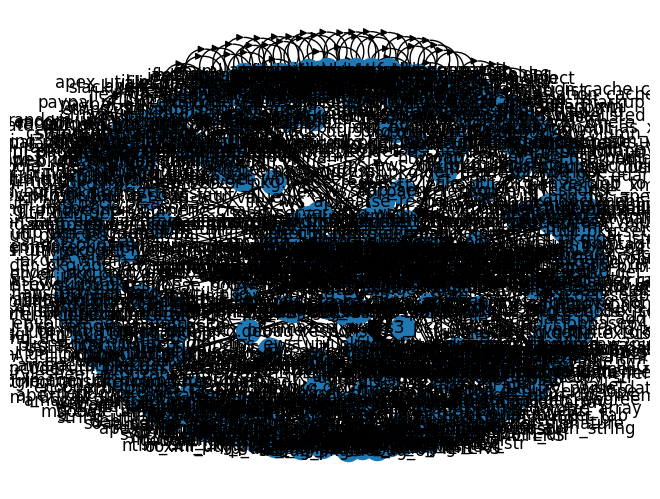

In [22]:
plot_dependency_graph(filtered_procedures)